In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn import metrics

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

from IPython.display import Image
from six import StringIO
import graphviz
import pydot

In [2]:
ccdata = pd.read_csv('BankChurners.csv')

In [3]:
ccdata.drop("CLIENTNUM",axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',axis=1,inplace=True)
ccdata['Gender'].replace({'M':1,'F':0},inplace=True)
ccdata["Attrition_Flag"].replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)
ccdata2 = pd.get_dummies(data=ccdata,columns=['Education_Level','Marital_Status',"Income_Category",'Card_Category'],drop_first=True)
ccdata2.drop(['Avg_Open_To_Buy','Customer_Age','Total_Trans_Ct','Months_on_book','Total_Amt_Chng_Q4_Q1'],axis=1,inplace=True)

In [4]:
X = ccdata2.drop("Attrition_Flag",axis=1)
y = ccdata2['Attrition_Flag']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

## hyperparameter optimization

In [11]:
randfor = RandomForestClassifier()

In [21]:
from sklearn.model_selection import GridSearchCV
#round 1
randforparam_grid = [
    {
        'criterion':['gini','entropy'],
        'n_estimators':[1,5,10,20,50,60,70,80,90,100],
        'max_depth':[5,10,15,20,25],
        'min_samples_leaf':[20,30,40,50,60]
    }
]

In [19]:
clf = GridSearchCV(randfor, param_grid = randforparam_grid, cv = 5, verbose=True, n_jobs = -1)

In [20]:
best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [22]:
rawresults = pd.DataFrame(best_clf.cv_results_)
#rawresults

In [23]:
best_clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       n_estimators=10)

In [24]:
best_clf.best_score_

0.9115413978756844

## preliminary testing

In [6]:
from randforestmodule import randforest

randforestmodule.py is being imported into another module


In [7]:
rf1 = randforest(X_train,X_test,y_train,y_test)
rf1.KPI_summary()

accuracy score =  91.12 %
recall =  52.87 %
precision =  86.58 %
f2_score =  57.33 %
training accuracy =  92.06 %
testing accuracy =  91.12 %


                     Feature_names  Importances    cumsum
0                  Total_Trans_Amt     0.318356  0.318356
1              Total_Revolving_Bal     0.185008  0.503364
2              Total_Ct_Chng_Q4_Q1     0.166808  0.670172
3            Avg_Utilization_Ratio     0.095371  0.765543
4         Total_Relationship_Count     0.069412  0.834955
5           Months_Inactive_12_mon     0.041149  0.876104
6                     Credit_Limit     0.036989  0.913094
7            Contacts_Count_12_mon     0.036330  0.949424
8                           Gender     0.012649  0.962073
9                  Dependent_count     0.010301  0.972374
10          Marital_Status_Married     0.004661  0.977035
11    Income_Category_$80K - $120K     0.004523  0.981558
12           Marital_Status_Single     0.003944  0.985502
13        Education_Level_Graduate     0.002190  0.987692
14  Income_Category_Less than $40K     0.002117  0.989809
15     Income_Category_$40K - $60K     0.001965  0.991775
16     Income_

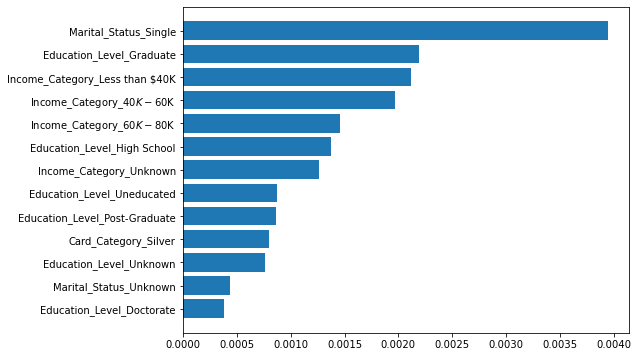

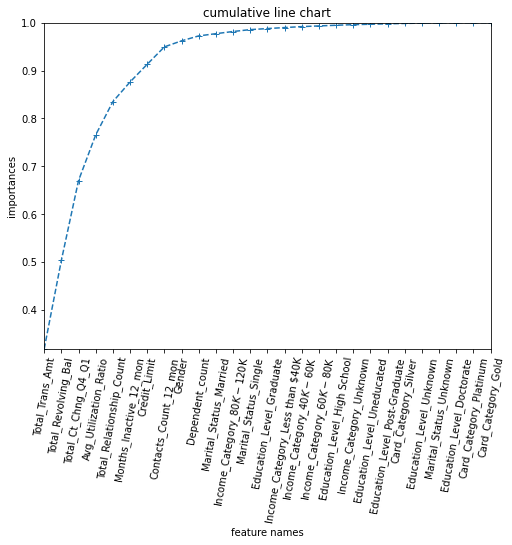

In [8]:
rf1.feature_importance()

In [9]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm, y_sm = smote.fit_resample(X_train,y_train)

print(y_sm.value_counts())
#generate train test split first then do resampling only on training set

#########

##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train3, y_train3 = pipeline.fit_resample(X_train,y_train)
print(y_train3.value_counts())

0    5949
1    5949
Name: Attrition_Flag, dtype: int64
0    3965
1    2379
Name: Attrition_Flag, dtype: int64


In [10]:
rf2 = randforest(X_sm,X_test,y_sm,y_test)
rf3 = randforest(X_train3,X_test,y_train3,y_test)

In [11]:
ls = [rf1,rf2,rf3]
[print(x.KPI_summary()) for x in ls]

accuracy score =  91.12 %
recall =  52.87 %
precision =  86.58 %
f2_score =  57.33 %
training accuracy =  92.06 %
testing accuracy =  91.12 %
None
accuracy score =  91.02 %
recall =  79.1 %
precision =  69.3 %
f2_score =  76.92 %
training accuracy =  93.64 %
testing accuracy =  91.02 %
None
accuracy score =  91.44 %
recall =  76.64 %
precision =  71.92 %
f2_score =  75.65 %
training accuracy =  91.93 %
testing accuracy =  91.44 %
None


[None, None, None]

## post-feature selection 

In [12]:
#feature selection
X_train2 = X_train.drop(['Marital_Status_Married','Marital_Status_Single','Income_Category_$80K - $120K','Income_Category_$80K - $120K','Income_Category_Less than $40K','Education_Level_Graduate','Education_Level_Post-Graduate','Education_Level_Unknown','Income_Category_Unknown','Income_Category_$60K - $80K','Education_Level_High School','Income_Category_$40K - $60K','Education_Level_Uneducated','Education_Level_Doctorate','Card_Category_Silver','Marital_Status_Unknown','Card_Category_Gold','Card_Category_Platinum'],axis=1)
X_test2 = X_test.drop(['Marital_Status_Married','Marital_Status_Single','Income_Category_$80K - $120K','Income_Category_$80K - $120K','Income_Category_Less than $40K','Education_Level_Graduate','Education_Level_Post-Graduate','Education_Level_Unknown','Income_Category_Unknown','Income_Category_$60K - $80K','Education_Level_High School','Income_Category_$40K - $60K','Education_Level_Uneducated','Education_Level_Doctorate','Card_Category_Silver','Marital_Status_Unknown','Card_Category_Gold','Card_Category_Platinum'],axis=1)

In [13]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm2, y_sm2 = smote.fit_resample(X_train2,y_train)

y_sm2.value_counts()
#generate train test split first then do resampling only on training set

##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train4, y_train4 = pipeline.fit_resample(X_train2,y_train)
y_train4.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

In [14]:
rf4 = randforest(X_train2,X_test2,y_train,y_test)
rf5 = randforest(X_sm2,X_test2,y_sm2,y_test)
rf6 = randforest(X_train4,X_test2,y_train4,y_test)

In [15]:
ls1 = [rf4,rf5,rf6]
[print(x.f2_score) for x in ls]
[print(x.f2_score) for x in ls1]

0.5733333333333333
0.7692307692307693
0.756472491909385
0.6632213608957794
0.8245614035087719
0.8349590323839251


[None, None, None]

## class weight rebalanced (pre & post-feature selection)

In [16]:
from randforestmodule import randforest_rebalanced

In [17]:
rf7 = randforest_rebalanced(X_train,X_test,y_train,y_test)
rf8 = randforest_rebalanced(X_sm,X_test,y_sm,y_test)
rf9 = randforest_rebalanced(X_train3,X_test,y_train3,y_test)
rf10 = randforest_rebalanced(X_train2,X_test2,y_train,y_test)
rf11 = randforest_rebalanced(X_sm2,X_test2,y_sm2,y_test)
rf12 = randforest_rebalanced(X_train4,X_test2,y_train4,y_test)

In [18]:
ls2 = [rf7,rf8,rf9,rf10,rf11,rf12]
[print(x.f2_score) for x in ls2]

0.8307692307692307
0.7704527402700556
0.7785795670338017
0.8362035973976272
0.8216237314597971
0.8415094339622642


[None, None, None, None, None, None]

In [19]:
#f2 score for rf1 to rf12
[print(x.f2_score) for x in ls]
[print(x.f2_score) for x in ls1]
[print(x.f2_score) for x in ls2]

0.5733333333333333
0.7692307692307693
0.756472491909385
0.6632213608957794
0.8245614035087719
0.8349590323839251
0.8307692307692307
0.7704527402700556
0.7785795670338017
0.8362035973976272
0.8216237314597971
0.8415094339622642


[None, None, None, None, None, None]

In [20]:
rf12.KPI_summary()

accuracy score =  90.33 %
recall =  91.39 %
precision =  63.9 %
f2_score =  84.15 %
training accuracy =  92.29 %
testing accuracy =  90.33 %


              Feature_names  Importances    cumsum
0           Total_Trans_Amt     0.400180  0.400180
1       Total_Ct_Chng_Q4_Q1     0.182275  0.582455
2       Total_Revolving_Bal     0.101948  0.684403
3     Avg_Utilization_Ratio     0.092498  0.776900
4  Total_Relationship_Count     0.090312  0.867213
5              Credit_Limit     0.056830  0.924043
6                    Gender     0.032179  0.956222
7    Months_Inactive_12_mon     0.017042  0.973264
8     Contacts_Count_12_mon     0.014878  0.988142
9           Dependent_count     0.011858  1.000000


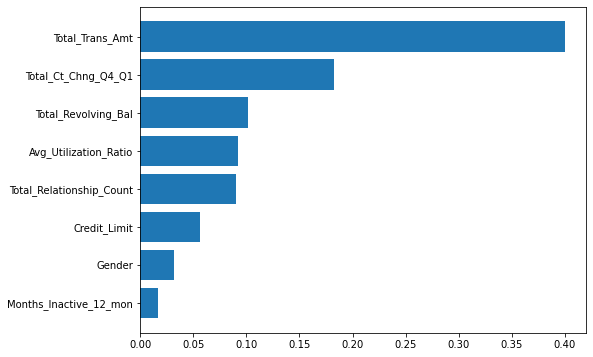

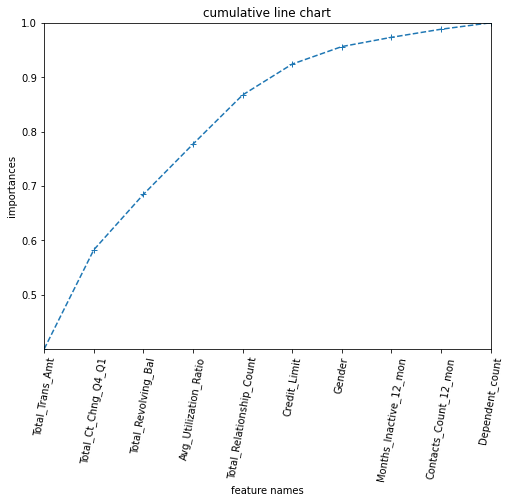

In [21]:
rf12.feature_importance()